In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('ratings.csv')
df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [3]:
df2 = pd.read_csv('movies.csv')
df2.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
df['title'] = ''
df['genres'] = ''
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,,
1,1,3,4.0,964981247,,
2,1,6,4.0,964982224,,


In [5]:
for id in df['movieId'].unique():
  df.loc[df['movieId'] == id, 'title'] = df2.loc[df2['movieId'] == id,'title'].values[0]
  df.loc[df['movieId'] == id, 'genres'] = df2.loc[df2['movieId'] == id,'genres'].values[0]

In [6]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Creating fake profiles

In [7]:
adult = df[df['genres'].str.contains('Horror')].groupby(by='title').count().sort_values(by='rating', ascending=False)[:10].index
children = df[df['genres'].str.contains('Children')].groupby(by='title').count().sort_values(by='rating', ascending=False)[:10].index
profile_movies = children.append(adult)

In [8]:
child_df = pd.DataFrame( columns=['userId', 'rating'])
adult_df = pd.DataFrame( columns=['userId', 'rating'])

In [9]:
child_df['userId'] = np.repeat(611,20)
child_df['rating'] = np.append(np.repeat(5,10),(np.repeat(1,10)))
child_df['title'] = profile_movies
##
adult_df['userId'] = np.repeat(611,20)
adult_df['rating'] = np.append(np.repeat(1,10),(np.repeat(5,10)))
adult_df['title'] = profile_movies

In [10]:
child_df = df.append(child_df, ignore_index=True)
adult_df = df.append(adult_df, ignore_index=True)

In [11]:
pip install surprise

     |████████████████████████████████| 11.8MB 325kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617545 sha256=8606ea052e5c0920a1932c537d98ba5943b94d084fc9de3e0bdebe6336e387ba
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Validation

In [12]:
# Imports
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD, SVDpp, NMF


In [13]:
print('No. of Unique Users    :', df.userId.nunique())
print('No. of Unique Movies :', df.movieId.nunique())
print('No. of Unique Ratings  :', df.rating.nunique())

No. of Unique Users    : 610
No. of Unique Movies : 9724
No. of Unique Ratings  : 10


In [14]:
rts_gp = df.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

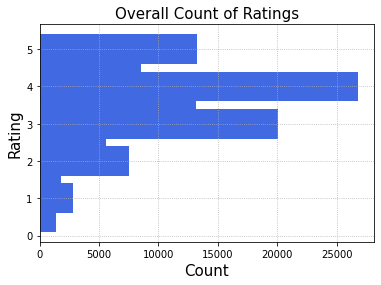

In [15]:
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

In [16]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)

## Matrix Factorization Based Algorithms


In [17]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)

## Comparison of all algorithms on RMSE and MAE


In [18]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

SVD 		 0.8734 	 0.6713
SVDpp 		 0.8599 	 0.659
NMF 		 0.9217 	 0.7047



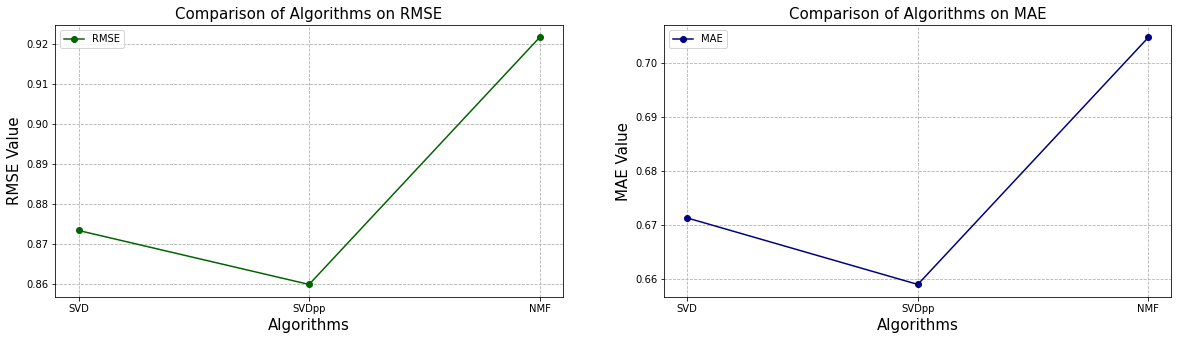

In [19]:
x_algo = ['SVD', 'SVDpp', 'NMF']
all_algos_cv = [svd_cv, svdpp_cv, nmf_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

# GridSearch

In [21]:
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.001, 0.003, 0.09],
                  'reg_all': [0.4, 0.8]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)

## Predicting on child profile and adult profile

In [25]:
child_data = Dataset.load_from_df(child_df[['userId', 'title', 'rating']], reader)
child_trainset = child_data.build_full_trainset()

adult_data = Dataset.load_from_df(adult_df[['userId', 'title', 'rating']], reader)
adult_trainset = adult_data.build_full_trainset()

In [69]:
child_algo = SVD()
child_algo.fit(child_trainset)

adult_algo = SVD()
adult_algo.fit(adult_trainset)

In [49]:
all_titles = set(df.title.unique())
profile_titles = set(profile_movies)

In [51]:
titles_to_pred = all_titles - profile_titles

In [53]:
movies = []
pred_rating =[]
for title in titles_to_pred:
  movies.append(title)
  pred_rating.append(child_algo.predict(611, title).est)

In [68]:
pd.DataFrame(data=[movies, pred_rating]).T.sort_values(by=1, ascending=False)[:3]

,0,1
3955,Forrest Gump (1994),3.95388
3184,North by Northwest (1959),3.91273
5298,Wallace & Gromit: The Wrong Trousers (1993),3.84089


In [70]:
movies = []
pred_rating =[]
for title in titles_to_pred:
  movies.append(title)
  pred_rating.append(adult_algo.predict(611, title).est)

In [71]:
pd.DataFrame(data=[movies, pred_rating]).T.sort_values(by=1, ascending=False)[:3]

,0,1
8540,Reservoir Dogs (1992),4.17552
5473,Fight Club (1999),4.02935
6733,Eternal Sunshine of the Spotless Mind (2004),4.02088
